In [1]:
import os
import cv2
import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from geopandas import GeoSeries
from shapely.geometry import Polygon
from rasterio.windows import Window
from rasterio.plot import reshape_as_image

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Flatten, Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
%matplotlib inline

2022-07-31 23:22:07.312518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ymi/.virtualenvs/ws/lib/python3.8/site-packages/cv2/../../lib64:
2022-07-31 23:22:07.312547: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# read the labels dataframe
farmpin_data = pd.read_csv("/home/ymi/data/ucu_data/Farmpin_training.csv")

In [3]:
# find all images
dataset = os.listdir("/home/ymi/data/ucu_data/images_cropped_rgb")
farmIds = [int(img_name.split(".")[0]) for img_name in dataset]

In [4]:
# prepare the data
for num, row in farmpin_data.iterrows():
    img_path = os.path.join("/home/ymi/data/ucu_data/images_cropped_rgb", str(row['field_id']) + ".png")
    img = cv2.imread(img_path)
    if isinstance(img, np.ndarray):
        farmpin_data.loc[num, 'img_path'] = img_path
        farmpin_data.loc[num, 'size'] = img.shape[0] * img.shape[1]

[ WARN:0@2.808] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/1.png'): can't open/read file: check file path/integrity
[ WARN:0@2.809] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/2.png'): can't open/read file: check file path/integrity
[ WARN:0@2.809] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/3.png'): can't open/read file: check file path/integrity
[ WARN:0@2.809] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/4.png'): can't open/read file: check file path/integrity
[ WARN:0@2.810] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/7.png'): can't open/read file: check file path/integrity
[ WARN:0@2.810] glob

[ WARN:0@3.423] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/1170.png'): can't open/read file: check file path/integrity
[ WARN:0@3.724] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/1685.png'): can't open/read file: check file path/integrity
[ WARN:0@3.975] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/2156.png'): can't open/read file: check file path/integrity
[ WARN:0@3.975] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/2157.png'): can't open/read file: check file path/integrity
[ WARN:0@3.975] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/2158.png'): can't open/read file: check file path/integrity
[ WAR

[ WARN:0@4.543] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/3244.png'): can't open/read file: check file path/integrity
[ WARN:0@4.543] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/3245.png'): can't open/read file: check file path/integrity
[ WARN:0@4.543] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/3247.png'): can't open/read file: check file path/integrity
[ WARN:0@4.543] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/3248.png'): can't open/read file: check file path/integrity
[ WARN:0@4.625] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/3428.png'): can't open/read file: check file path/integrity
[ WAR

In [6]:
# filter fields with area higher than 15 pixels 

farmpin_data.dropna(inplace=True)

farmpin_data['size'].min()

farmpin_data = farmpin_data[farmpin_data['size'] >= 15]

8.0

In [12]:
# prepare y labels
farmpin_data['crop_id'] = farmpin_data['crop_id'] - 1

y = to_categorical(farmpin_data['crop_id'].tolist(), num_classes = 9)

In [13]:
def load_image(img_path):
      
    img = cv2.imread(img_path)

    return img

In [14]:
def crop_image(image, w, h):
    center = np.array(image.shape) / 2
    x = int(center[1] - w/2)
    y = int(center[0] - h/2)
    crop_img = image[int(y):int(y+h), int(x):int(x+w), :]
    return crop_img

In [15]:
#generate X
def generate_X(img_list, w, h):
    input_size = int(w * h * 3)
    X = np.empty((len(img_list), input_size))

    for i, item in enumerate(img_list):
        img = load_image(item)
        # print(img.shape)
        if img.shape[0] > h and img.shape[1] > h:
            img = crop_image(img, w, h)
        img = img.flatten()
        if img.shape[0] > input_size:
            img = img[:input_size]
        X[i,] = img
    
    # normalize 
    X = X / 127.5
    X -= 1.0
    return X


In [16]:
X_train = generate_X(farmpin_data['img_path'], 4, 4)
X_train.shape

(2341, 48)

In [17]:
y.shape

(2341, 9)

In [40]:
def build_model_dense(input_shape, num_classes):
    inputs = Input(input_shape)
    
    # 32 layers with sigmoid activation
    # 16 layers
    # output with softmax activation
    hidden_1 = Dense(32, activation = 'relu')(inputs)
    hidden_2 = Dense(16, activation = 'relu')(hidden_1)
    outputs = Dense(num_classes, activation = 'softmax')(hidden_2)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    
    return model


In [50]:
# create model with input 48 and output 9



In [51]:
# check model summary 

In [43]:

model_checkpoint = ModelCheckpoint("model_class.hdf5", save_best_only=True, verbose=1, monitor='accuracy', mode='max')

In [52]:
# compile model with tf.keras.optimizers.Adam(0.001), loss tf.keras.losses.CategoricalCrossentropy(from_logits=False), tf.keras.metrics.CategoricalAccuracy()]

In [53]:
# fit model
classification_model.fit(X_train,
          y,
          batch_size=256, 
          epochs=1000,
          verbose=1,
          callbacks=[model_checkpoint])

Epoch 1/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2029 - categorical_accuracy: 0.5993
Epoch 2/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1994 - categorical_accuracy: 0.5963
Epoch 3/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1908 - categorical_accuracy: 0.6044
Epoch 4/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1951 - categorical_accuracy: 0.6044
Epoch 5/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1926 - categorical_accuracy: 0.6019
Epoch 6/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1979 - categorical_accuracy: 0.6006
Epoch 7/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2129 - categorical_accuracy: 0.5959
Epoch 8/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1978 - categorical_accuracy: 0.6010
Epoch 9/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1919 - categorical_accuracy:

Epoch 44/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1928 - categorical_accuracy: 0.6027
Epoch 45/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2001 - categorical_accuracy: 0.6023
Epoch 46/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1896 - categorical_accuracy: 0.5993
Epoch 47/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1915 - categorical_accuracy: 0.6066
Epoch 48/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1899 - categorical_accuracy: 0.6113
Epoch 49/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1876 - categorical_accuracy: 0.6053
Epoch 50/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1908 - categorical_accuracy: 0.6100
Epoch 51/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1900 - categorical_accuracy: 0.6053
Epoch 52/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1923 - categorical_

Epoch 87/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1834 - categorical_accuracy: 0.6079
Epoch 88/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1831 - categorical_accuracy: 0.6134
Epoch 89/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1828 - categorical_accuracy: 0.6057
Epoch 90/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1824 - categorical_accuracy: 0.6091
Epoch 91/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1804 - categorical_accuracy: 0.6138
Epoch 92/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1817 - categorical_accuracy: 0.6109
Epoch 93/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1842 - categorical_accuracy: 0.6053
Epoch 94/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1828 - categorical_accuracy: 0.6070
Epoch 95/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1824 - categorical_

10/10 [==============================] - 0s 2ms/step - loss: 1.1855 - categorical_accuracy: 0.6087
Epoch 130/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2028 - categorical_accuracy: 0.5997
Epoch 131/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1877 - categorical_accuracy: 0.6083
Epoch 132/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1782 - categorical_accuracy: 0.6113
Epoch 133/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1926 - categorical_accuracy: 0.6010
Epoch 134/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1862 - categorical_accuracy: 0.6104
Epoch 135/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1916 - categorical_accuracy: 0.6040
Epoch 136/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1839 - categorical_accuracy: 0.6074
Epoch 137/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1922 - categorical_accura

10/10 [==============================] - 0s 2ms/step - loss: 1.1727 - categorical_accuracy: 0.6130
Epoch 172/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1701 - categorical_accuracy: 0.6164
Epoch 173/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1777 - categorical_accuracy: 0.6062
Epoch 174/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1811 - categorical_accuracy: 0.6002
Epoch 175/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1729 - categorical_accuracy: 0.6113
Epoch 176/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1700 - categorical_accuracy: 0.6155
Epoch 177/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1828 - categorical_accuracy: 0.6027
Epoch 178/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1763 - categorical_accuracy: 0.6104
Epoch 179/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1722 - categorical_accura

10/10 [==============================] - 0s 2ms/step - loss: 1.1710 - categorical_accuracy: 0.6121
Epoch 214/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1823 - categorical_accuracy: 0.5976
Epoch 215/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1894 - categorical_accuracy: 0.5976
Epoch 216/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1781 - categorical_accuracy: 0.6091
Epoch 217/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1705 - categorical_accuracy: 0.6130
Epoch 218/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1777 - categorical_accuracy: 0.6113
Epoch 219/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1766 - categorical_accuracy: 0.6083
Epoch 220/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1725 - categorical_accuracy: 0.6044
Epoch 221/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1743 - categorical_accura

10/10 [==============================] - 0s 2ms/step - loss: 1.1647 - categorical_accuracy: 0.6151
Epoch 256/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1795 - categorical_accuracy: 0.6057
Epoch 257/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1684 - categorical_accuracy: 0.6207
Epoch 258/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1655 - categorical_accuracy: 0.6151
Epoch 259/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1983 - categorical_accuracy: 0.5963
Epoch 260/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1781 - categorical_accuracy: 0.6117
Epoch 261/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1800 - categorical_accuracy: 0.6074
Epoch 262/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1764 - categorical_accuracy: 0.6147
Epoch 263/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1852 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.1653 - categorical_accuracy: 0.6168
Epoch 298/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1606 - categorical_accuracy: 0.6164
Epoch 299/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1689 - categorical_accuracy: 0.6147
Epoch 300/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1755 - categorical_accuracy: 0.6109
Epoch 301/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1626 - categorical_accuracy: 0.6147
Epoch 302/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1619 - categorical_accuracy: 0.6237
Epoch 303/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1655 - categorical_accuracy: 0.6181
Epoch 304/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1590 - categorical_accuracy: 0.6215
Epoch 305/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1718 - categorical_accura

10/10 [==============================] - 0s 2ms/step - loss: 1.1594 - categorical_accuracy: 0.6160
Epoch 340/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1609 - categorical_accuracy: 0.6130
Epoch 341/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1710 - categorical_accuracy: 0.6143
Epoch 342/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1694 - categorical_accuracy: 0.6079
Epoch 343/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1626 - categorical_accuracy: 0.6155
Epoch 344/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1630 - categorical_accuracy: 0.6151
Epoch 345/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1531 - categorical_accuracy: 0.6224
Epoch 346/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1685 - categorical_accuracy: 0.6096
Epoch 347/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1792 - categorical_accura

10/10 [==============================] - 0s 2ms/step - loss: 1.1572 - categorical_accuracy: 0.6138
Epoch 382/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1537 - categorical_accuracy: 0.6232
Epoch 383/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1550 - categorical_accuracy: 0.6232
Epoch 384/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1527 - categorical_accuracy: 0.6181
Epoch 385/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1537 - categorical_accuracy: 0.6185
Epoch 386/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1536 - categorical_accuracy: 0.6185
Epoch 387/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1563 - categorical_accuracy: 0.6181
Epoch 388/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1789 - categorical_accuracy: 0.6096
Epoch 389/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1594 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.1526 - categorical_accuracy: 0.6185
Epoch 424/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1553 - categorical_accuracy: 0.6181
Epoch 425/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1584 - categorical_accuracy: 0.6151
Epoch 426/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1567 - categorical_accuracy: 0.6190
Epoch 427/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1506 - categorical_accuracy: 0.6168
Epoch 428/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1555 - categorical_accuracy: 0.6164
Epoch 429/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1636 - categorical_accuracy: 0.6143
Epoch 430/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1512 - categorical_accuracy: 0.6194
Epoch 431/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1544 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.1490 - categorical_accuracy: 0.6190
Epoch 466/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1491 - categorical_accuracy: 0.6207
Epoch 467/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1524 - categorical_accuracy: 0.6185
Epoch 468/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1470 - categorical_accuracy: 0.6194
Epoch 469/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1510 - categorical_accuracy: 0.6168
Epoch 470/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1576 - categorical_accuracy: 0.6147
Epoch 471/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1548 - categorical_accuracy: 0.6164
Epoch 472/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1647 - categorical_accuracy: 0.6185
Epoch 473/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1588 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.1457 - categorical_accuracy: 0.6262
Epoch 508/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1443 - categorical_accuracy: 0.6267
Epoch 509/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1468 - categorical_accuracy: 0.6185
Epoch 510/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1528 - categorical_accuracy: 0.6151
Epoch 511/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1504 - categorical_accuracy: 0.6202
Epoch 512/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1460 - categorical_accuracy: 0.6202
Epoch 513/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1451 - categorical_accuracy: 0.6224
Epoch 514/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1430 - categorical_accuracy: 0.6237
Epoch 515/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1402 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.1415 - categorical_accuracy: 0.6220
Epoch 550/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1395 - categorical_accuracy: 0.6228
Epoch 551/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1456 - categorical_accuracy: 0.6168
Epoch 552/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1425 - categorical_accuracy: 0.6262
Epoch 553/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1434 - categorical_accuracy: 0.6232
Epoch 554/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1525 - categorical_accuracy: 0.6138
Epoch 555/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1545 - categorical_accuracy: 0.6185
Epoch 556/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1409 - categorical_accuracy: 0.6267
Epoch 557/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1401 - categorical_accura

10/10 [==============================] - 0s 4ms/step - loss: 1.2145 - categorical_accuracy: 0.5844
Epoch 592/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1563 - categorical_accuracy: 0.6194
Epoch 593/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1548 - categorical_accuracy: 0.6138
Epoch 594/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1388 - categorical_accuracy: 0.6232
Epoch 595/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1397 - categorical_accuracy: 0.6241
Epoch 596/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1575 - categorical_accuracy: 0.6151
Epoch 597/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1485 - categorical_accuracy: 0.6168
Epoch 598/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1508 - categorical_accuracy: 0.6190
Epoch 599/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1388 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.1300 - categorical_accuracy: 0.6245
Epoch 634/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1425 - categorical_accuracy: 0.6173
Epoch 635/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1513 - categorical_accuracy: 0.6164
Epoch 636/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1462 - categorical_accuracy: 0.6224
Epoch 637/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1845 - categorical_accuracy: 0.6019
Epoch 638/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1369 - categorical_accuracy: 0.6228
Epoch 639/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1358 - categorical_accuracy: 0.6220
Epoch 640/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1313 - categorical_accuracy: 0.6241
Epoch 641/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1366 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.1307 - categorical_accuracy: 0.6267
Epoch 676/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1343 - categorical_accuracy: 0.6207
Epoch 677/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1395 - categorical_accuracy: 0.6249
Epoch 678/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1405 - categorical_accuracy: 0.6232
Epoch 679/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1463 - categorical_accuracy: 0.6173
Epoch 680/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1412 - categorical_accuracy: 0.6185
Epoch 681/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1690 - categorical_accuracy: 0.6066
Epoch 682/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1439 - categorical_accuracy: 0.6155
Epoch 683/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1378 - categorical_accura

10/10 [==============================] - 0s 2ms/step - loss: 1.1356 - categorical_accuracy: 0.6232
Epoch 718/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1354 - categorical_accuracy: 0.6237
Epoch 719/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1286 - categorical_accuracy: 0.6288
Epoch 720/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1270 - categorical_accuracy: 0.6254
Epoch 721/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1387 - categorical_accuracy: 0.6173
Epoch 722/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1325 - categorical_accuracy: 0.6241
Epoch 723/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1267 - categorical_accuracy: 0.6258
Epoch 724/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1270 - categorical_accuracy: 0.6258
Epoch 725/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1272 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.1287 - categorical_accuracy: 0.6224
Epoch 760/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1263 - categorical_accuracy: 0.6271
Epoch 761/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1339 - categorical_accuracy: 0.6228
Epoch 762/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1339 - categorical_accuracy: 0.6296
Epoch 763/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1274 - categorical_accuracy: 0.6271
Epoch 764/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1402 - categorical_accuracy: 0.6147
Epoch 765/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1530 - categorical_accuracy: 0.6202
Epoch 766/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1238 - categorical_accuracy: 0.6275
Epoch 767/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1268 - categorical_accura

10/10 [==============================] - 0s 2ms/step - loss: 1.1507 - categorical_accuracy: 0.6138
Epoch 802/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1411 - categorical_accuracy: 0.6143
Epoch 803/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1384 - categorical_accuracy: 0.6207
Epoch 804/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1362 - categorical_accuracy: 0.6198
Epoch 805/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1327 - categorical_accuracy: 0.6279
Epoch 806/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1307 - categorical_accuracy: 0.6267
Epoch 807/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1267 - categorical_accuracy: 0.6241
Epoch 808/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1252 - categorical_accuracy: 0.6339
Epoch 809/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1219 - categorical_accura

10/10 [==============================] - 0s 2ms/step - loss: 1.1225 - categorical_accuracy: 0.6318
Epoch 844/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1455 - categorical_accuracy: 0.6130
Epoch 845/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1310 - categorical_accuracy: 0.6305
Epoch 846/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1335 - categorical_accuracy: 0.6254
Epoch 847/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1320 - categorical_accuracy: 0.6185
Epoch 848/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1465 - categorical_accuracy: 0.6168
Epoch 849/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1292 - categorical_accuracy: 0.6296
Epoch 850/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1333 - categorical_accuracy: 0.6232
Epoch 851/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1263 - categorical_accura

10/10 [==============================] - 0s 2ms/step - loss: 1.1322 - categorical_accuracy: 0.6258
Epoch 886/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1208 - categorical_accuracy: 0.6202
Epoch 887/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1276 - categorical_accuracy: 0.6207
Epoch 888/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1168 - categorical_accuracy: 0.6284
Epoch 889/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1248 - categorical_accuracy: 0.6232
Epoch 890/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1306 - categorical_accuracy: 0.6249
Epoch 891/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1257 - categorical_accuracy: 0.6267
Epoch 892/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1159 - categorical_accuracy: 0.6331
Epoch 893/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1189 - categorical_accura

10/10 [==============================] - 0s 2ms/step - loss: 1.1199 - categorical_accuracy: 0.6309
Epoch 928/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1135 - categorical_accuracy: 0.6279
Epoch 929/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1179 - categorical_accuracy: 0.6284
Epoch 930/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1166 - categorical_accuracy: 0.6331
Epoch 931/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1137 - categorical_accuracy: 0.6249
Epoch 932/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1205 - categorical_accuracy: 0.6241
Epoch 933/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1218 - categorical_accuracy: 0.6224
Epoch 934/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1186 - categorical_accuracy: 0.6245
Epoch 935/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1220 - categorical_accura

10/10 [==============================] - 0s 2ms/step - loss: 1.1112 - categorical_accuracy: 0.6301
Epoch 970/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1112 - categorical_accuracy: 0.6296
Epoch 971/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1139 - categorical_accuracy: 0.6249
Epoch 972/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1219 - categorical_accuracy: 0.6237
Epoch 973/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1220 - categorical_accuracy: 0.6296
Epoch 974/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1203 - categorical_accuracy: 0.6262
Epoch 975/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1138 - categorical_accuracy: 0.6305
Epoch 976/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1145 - categorical_accuracy: 0.6318
Epoch 977/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1123 - categorical_accura

In [58]:
# predict X_train


In [60]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

<AxesSubplot:>

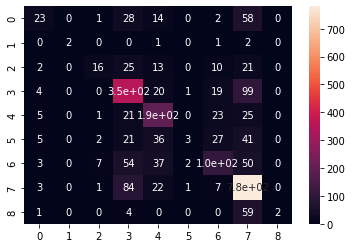

In [61]:
conf_matrix = confusion_matrix(farmpin_data['crop_id'].tolist(), np.argmax(y_pred, axis=1))
sns.heatmap(conf_matrix, annot=True)

In [ ]:
# task create train, val, test split 
# train model with X_train, y_train, X_val, y_val
# and predict on X_test, y_test